# Delineate Ridge Areas
This notebook will delineate the ridge areas from the input DEM.

Ridge area delineation is accomplished with the following operations:
1. apply profile curvature and residual topography transformations
2. apply binary classification to the transformed rasters
3. find the agreement between the binary rasters
4. denoise the agreement raster


## Flow within each class
Each of the geoprocessing steps outlined above is handled by a separate raster processing `class` which all operate in the same basic way
- each class will take the input raster file path, the output directory, and any other required parameters as inputs
- calling the `.execute()` method on the class instance will perform all required operations for the class including writing the output raster to disk in the output directory


In [1]:
from pathlib import Path

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

from parameters import RASTER_WINDOW_SIZE
from scrollstats.delineation import CalcResidualTopography, BinaryClassifier, RasterAgreementAssessor, RasterClipper, RasterDenoiser

## Define Inputs

### Set input paths and output directory

In [2]:
# Input Paths
dem_path = Path("example_data/input/LBR_025_dem.tif")
profc_path = Path("example_data/output/LBR_025_dem_profc45px.tif")
rt_path = Path("example_data/output/LBR_025_dem_rt45px.tif")
raster_paths = [profc_path, rt_path]

bend_path = Path("example_data/input/LBR_025_bend.geojson")

# Output Directory
output_dir = Path("example_data/output")

## Calculate profile curvature with QGIS3

The script `profileCurvature_QGIS.py` (located at [scrollstats/delineation/profileCurvature_QGIS.py](scrollstats/delineation/profileCurvature_QGIS.py)) uses the `r.param.scale` tool in QGIS and should be used to calculate the profile curvature transform for the DEM. 

Execute `profileCurvature_QGIS.py` in the python console of QGIS. 

You can open the python console by clicking the python symbol in the tool bar
![launch python console](img/launch_python_console.png)

Then click the "show editor" button and open the script.
![show editor](img/open_script_editor.png)

Alter the input parameters and run the script
- set the `dem_path`, `output_dir`, and `window_size` variables to the same values used in this notebook.
![run the script](img/run_script.png)


In [3]:
assert profc_path.is_file(), "Profile Curvature raster needs to be created before proceeding"

## Calculate Residual Topography
- provide the dem path, the processing window size, and the output directory to the `CalcResidualTopography` class
- Call the `.execute()` method to calculate the transformation and save the transformed raster to the output directory
- This process may take several seconds to complete; especially for larger window sizes. 
    - ~16s for `LBR_025_dem.tif` with a 45px window size

In [4]:
rt = CalcResidualTopography(dem_path, RASTER_WINDOW_SIZE, output_dir)
rt_path = rt.execute()

print(f"RT raster saved to {rt_path}")

RT raster saved to example_data/output/LBR_025_dem_rt45px.tif


## DEM vs Residual Topography example 

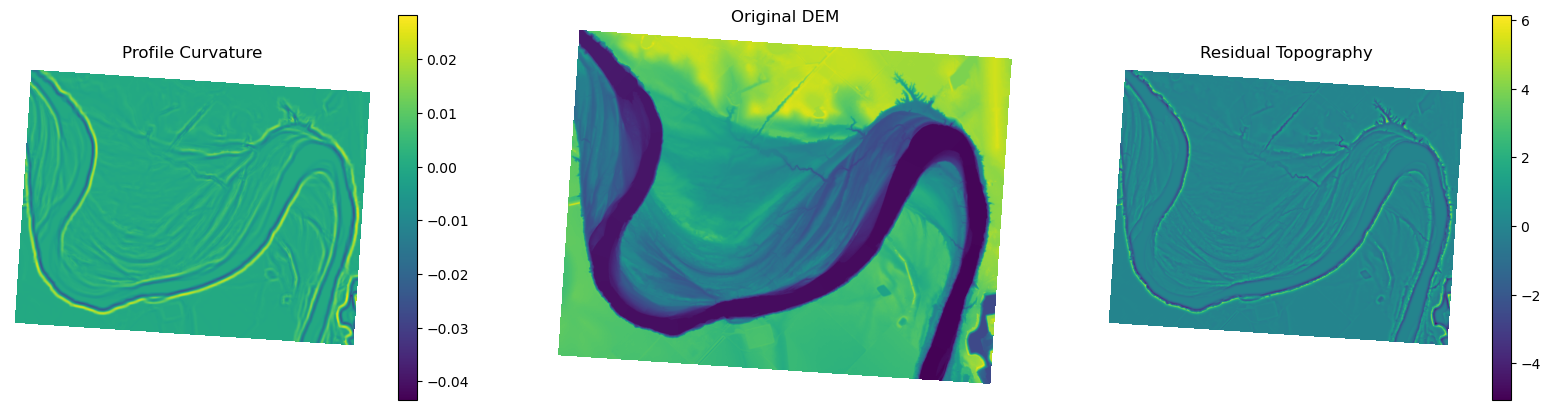

In [5]:
dem = rasterio.open(dem_path).read(1)
dem[dem<-1e6] = np.nan

profc = rasterio.open(profc_path).read(1)
rt = rasterio.open(rt_path).read(1)

fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))


mapper = ax1.imshow(profc)
fig.colorbar(mapper, ax=ax1)
ax1.set_axis_off()
ax1.set_title("Profile Curvature")

mapper = ax2.imshow(dem)
ax2.set_axis_off()
ax2.set_title("Original DEM")

mapper = ax3.imshow(rt)
fig.colorbar(mapper, ax=ax3)
ax3.set_axis_off()
ax3.set_title("Residual Topography");


## Create binary classification
- apply binary classification to both of the clipped rasters 

    ```python
    if px > 0:
        px == 1
    if px <= 0:
        px == 0
    ```

In [6]:
raster_paths = [profc_path, rt_path]

binclass_paths = []
for path in raster_paths:
    bc = BinaryClassifier(path, 0, output_dir)
    binclass_path = bc.execute()
    binclass_paths.append(binclass_path)

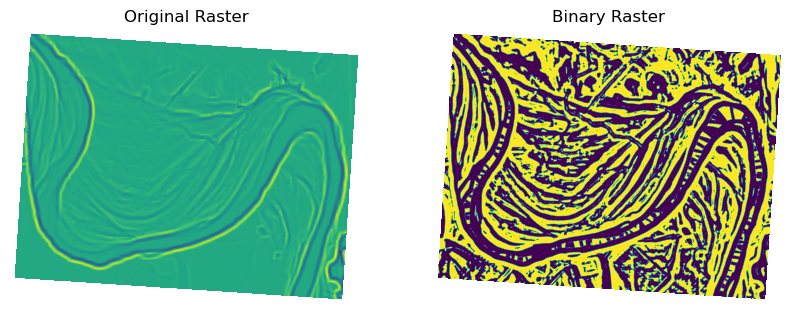

In [7]:
# Plot binary classification results
profc = rasterio.open(raster_paths[0]).read(1)
profc_bin = rasterio.open(binclass_paths[0]).read(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

mapper = ax1.imshow(profc)
ax1.set_axis_off()
ax1.set_title("Original Raster")

mapper = ax2.imshow(profc_bin)
ax2.set_axis_off()
ax2.set_title("Binary Raster");

### Create agreement raster

In [8]:
# Set parameters
bend_id = "LBR_025"
profc_binclass_path, rt_binclass_path = binclass_paths

ra = RasterAgreementAssessor(profc_binclass_path, rt_binclass_path, bend_id, output_dir)
agreement_path = ra.execute()

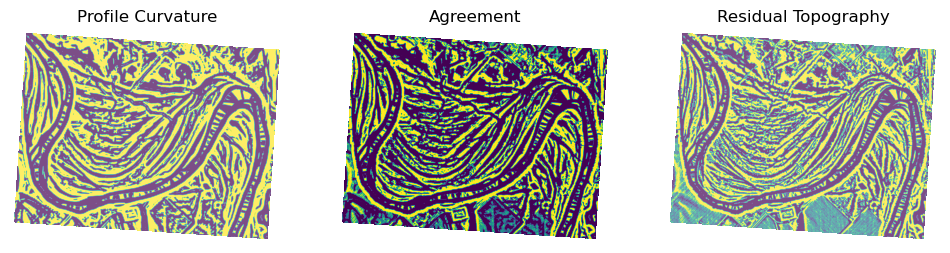

In [9]:
# Plot agreement results
profc = rasterio.open(profc_binclass_path).read(1)
rt = rasterio.open(rt_binclass_path).read(1)
agr = rasterio.open(agreement_path).read(1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

mapper = ax1.imshow(profc, alpha=0.7)
ax1.set_axis_off()
ax1.set_title("Profile Curvature")

mapper = ax2.imshow(agr)
ax2.set_axis_off()
ax2.set_title("Agreement")

mapper = ax3.imshow(rt, alpha=0.7)
ax3.set_axis_off()
ax3.set_title("Residual Topography");

### Clip DEM and Agreement raster

**NOTE:** Details on how to create the bend area polygon are contained in the next notebook, but the polygon is being used now to clip the rasters. 

This greatly reduces the number of raster features before denoising and keeps all of the raster processing in one notebook


In [10]:
bend = gpd.GeoDataFrame.from_file(bend_path)

raster_paths = [dem_path, agreement_path]

clip_paths = []
for raster_path in raster_paths:

    geom = bend["geometry"][0] # RasterClipper requires a shapely polygon, not geodataframe

    rc = RasterClipper(raster_path, geom, output_dir)
    clip_path = rc.execute()
    
    clip_paths.append(clip_path)

dem_clip_path, agreement_clip_path = clip_paths

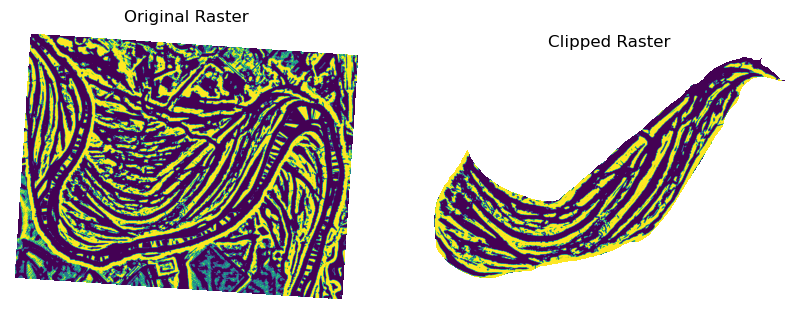

In [11]:
# Plot clip results
rt = rasterio.open(agreement_path).read(1)
rt_clip = rasterio.open(agreement_clip_path).read(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

mapper = ax1.imshow(rt)
ax1.set_axis_off()
ax1.set_title("Original Raster")


mapper = ax2.imshow(rt_clip)
ax2.set_axis_off()
ax2.set_title("Clipped Raster");

### Denoise agreement raster

In [12]:
# Set thresholds for denoising
small_feats_size = 500
elongation_threshold = 80

dn = RasterDenoiser(agreement_clip_path, small_feats_size, elongation_threshold, output_dir)
denoise_path = dn.execute()



Removing Small Features (<500px):
---------------------------------
Features in:  150
Features out:  41
Features removed:  109


Classifying Remaining Features (n=41)
-------------------------------------
Number of pixels in 5 largest patches:  [1536796   23811   21703   17092   13289]
Number of pixels in 5 largest patches after erosion:  [16093, 538, 258, 186, 80]


Filtering image for circular patches (ElongIndex > 80)
------------------------------------------------------
Features in:  41
Features out:  41
Features removed:  0


Removing Small Features (<500px):
---------------------------------
Features in:  169
Features out:  11
Features removed:  158


Classifying Remaining Features (n=11)
-------------------------------------
Number of pixels in 5 largest patches:  [434419  12641   2878   2355   1954]
Number of pixels in 5 largest patches after erosion:  [9394, 1372, 413, 369, 88]


Filtering image for circular patches (ElongIndex > 80)
----------------------------------------

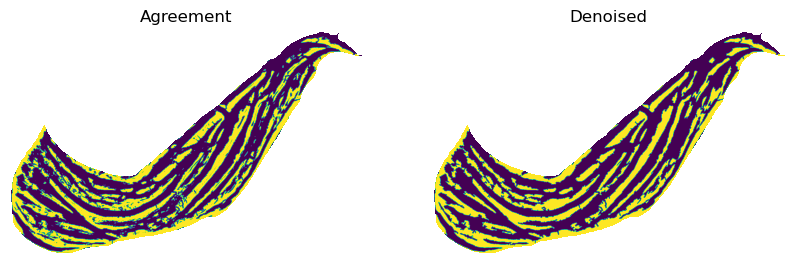

In [13]:
# Plot denoising results
agr = rasterio.open(agreement_clip_path).read(1)
denoise = rasterio.open(denoise_path).read(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

mapper = ax1.imshow(agr)
ax1.set_axis_off()
ax1.set_title("Agreement")

mapper = ax2.imshow(denoise)
ax2.set_axis_off()
ax2.set_title("Denoised");

## Move on to [`CreateVectorDatasets.ipynb`](CreateVectorDatasets.ipynb)
- [`CreateVectorDatasets.ipynb`](CreateVectorDatasets.ipynb) will walk through the processes and rationale for creating the vector datasets needed for ScrollStats
- The ridge area raster created from this notebook will be used in later notebooks
